Step 1: Find camera calibration matrix and distortion coefficient from the set of chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import re

# Camera matrix and distortion coefficient from chessboard images
def calibrate(images, nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = (img.shape[1], img.shape[0])

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            num = re.findall('[0-9]+', fname)
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            #write_name = 'corners_'+str(num[0])
            #cv2.imwrite("camera_cal/output/" + write_name + ".jpg", img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    return mtx, dist

# Camera matrix and distortion coefficient from calibration images
calibration_images = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = calibrate(calibration_images, 9, 6)

Step 2: Apply the distortion correction to raw images

In [2]:
# Images are distorted later on in the image pipeline
def undistort(image):
    # Undistort an image
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst

Step 3: Use color transforms, gradients, etc, to create a thresholded binary image

In [3]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function that thresholds the S-channel of HLS, and V-channel of HSV
def hls_select(img, sthresh=(0, 255), vthresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= vthresh[0]) & (v_channel <= vthresh[1])] = 1

    output = np.zeros_like(s_channel)
    output[(s_binary ==1) & (v_binary ==1)] =1

    return output

# Pipeline for applying color transform and gradients to image
def process_image(image):

    preprocessimage = np.zeros_like(image[:,:,0])

    gradx = abs_sobel_thresh(image, orient='x', thresh_min = 40, thresh_max = 100)
    grady = abs_sobel_thresh(image, orient='y', thresh_min = 25, thresh_max = 100)
    hls_binary = hls_select(image, sthresh=(130, 255), vthresh=(75, 255))

    preprocessimage[(gradx == 1) & (grady == 1) | (hls_binary == 1)] = 255

    return preprocessimage

Step 4: Apply a perspective transform to get a "bird's eye view" of the image

In [4]:
# Perspective transform to get a "birds eye view" of lane
def perspective_transform(image, src, dst):

    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warp = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_NEAREST)

    return warp

Step 5: Detect lane pixels and fit to find the lane boundary

In [5]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    lanes = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return lanes, left_fitx, right_fitx, ploty

Step 6: Find the curvature of lane and the vehicle position with respect to center

In [6]:
def measure_curvature(binary_warped):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Find lane pixels
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = ym_per_pix*np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def vehicle_position(image, left_pos, right_pos):

    # Define conversions in x from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Calculate position based on midpoint - center of lanes distance
    vehicle_center = (image.shape[1])/2
    lane_center = (left_pos + right_pos)/2
    position = vehicle_center - lane_center

    # Get value in meters
    vehicle_position = position*xm_per_pix

    return vehicle_position

Step 7: Warp the detected lane boundaries back onto the original image

In [7]:
# Function for adding lanes to original image
def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)



Step 8: Output visual display of lane boundaries and numerical estimation of the curvature and vehicle position

In [8]:
def draw_lanes(image, undist, Minv):

    lanes, left_fitx, right_fitx, ploty = search_around_poly(image)
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
        
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)

    left_curverad, right_curverad = measure_curvature(image)
    curvature = int((left_curverad + right_curverad)/2)
    curve_text = 'Radius of Curvature: ' + str(curvature) + ' m'
    output = cv2.putText(result, curve_text, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA, False)

    pos = vehicle_position(image, left_fitx, right_fitx)
    position = round(np.mean(pos), 3)
    if position <0:
        position_text = 'Vehicle Position: ' + str(np.absolute(position)) + ' m left of center'
    if position >0:
        position_text = 'Vehicle Position: ' + str(position) + ' m right of center'
    if position == 0:
        position_text = 'Vehicle Position: Center of Lane'
    output = cv2.putText(result, position_text, (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA, False)

    return output

Step 9: Using the above functions, here is a pipeline for processing the images

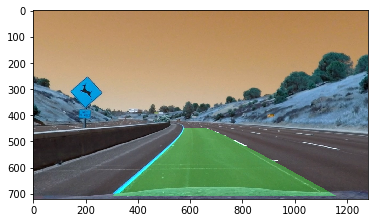

In [9]:
# Combine functions to process test images
def image_pipeline(images):
    for idx, fname in enumerate(images):
        image = cv2.imread(fname)
        num = re.findall('[0-9]+', fname)
        file_name = 'output' + str(num[0])
        img_size = (image.shape[1], image.shape[0])

        undist = cv2.undistort(image, mtx, dist, None, mtx)
        processed = process_image(undist)

        src = np.float32([[590, 450], [690, 450], [1120, 710], [160, 710]])
        dst = np.float32([[320, 0], [960, 0], [960, 720], [320, 720]])
        warp = perspective_transform(processed, src, dst)

        Minv = cv2.getPerspectiveTransform(dst, src)
        result = draw_lanes(warp, undist, Minv)
        
        cv2.imwrite("output_images/" + file_name + ".jpg", result)

images = glob.glob('test_images/test*.jpg')
image_pipeline(images)

Step 10: Pipeline for processing the project video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#imageio.plugins.ffmpeg.download()

def process_video(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # Undistorted frames
    img_size = (image.shape[1], image.shape[0])
    undist = cv2.undistort(image, mtx, dist, None, mtx)

    # Color and Gradient Thresholds
    processed = process_image(undist)

    # Warp frames
    src = np.float32([[590, 450], [690, 450], [1120, 710], [160, 710]])
    dst = np.float32([[320, 0], [960, 0], [960, 720], [320, 720]])
    warp = perspective_transform(processed, src, dst)

    # Draw lanes
    Minv = cv2.getPerspectiveTransform(dst, src)
    result = draw_lanes(warp, undist, Minv)
        
    return result


project_output = 'output_videos/output_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("P2_test_videos/project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_video) ##NOTE: this function expects color images!!
project_clip.write_videofile(project_output, audio=False)

HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(project_output))

[MoviePy] >>>> Building video output_videos/output_project_video.mp4
[MoviePy] Writing video output_videos/output_project_video.mp4


100%|█████████▉| 1260/1261 [06:03<00:00,  3.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_project_video.mp4 

